<a href="https://colab.research.google.com/github/aianshay/sales-time-series/blob/main/neural_net_svm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install yfinance --upgrade --no-cache-dir

     |████████████████████████████████| 6.4 MB 5.0 MB/s 
     |████████████████████████████████| 63 kB 38.8 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 4.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


# Imports

In [2]:
import yfinance as yf

from google.colab import drive

from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

In [6]:
mpl.rcParams['figure.figsize'] = [10, 5]
drive.mount('/content/drive')

Mounted at /content/drive


# Loading data

In [3]:
sales = pd.read_csv('/content/drive/MyDrive/data/store-sales/train.csv')
sales.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
sales.shape

(3000888, 6)

# Preprocessing

In [5]:
ts = sales.query('store_nbr == 1 and family == "PERSONAL CARE"')

In [6]:
ts = ts.drop(columns=['id', 'store_nbr', 'family', 'onpromotion'])

In [7]:
ts.shape

(1684, 2)

In [8]:
ts.head()

,date,sales
25,2013-01-01,0.0
1807,2013-01-02,194.0
3589,2013-01-03,153.0
5371,2013-01-04,88.0
7153,2013-01-05,141.0


In [9]:
ts.index = ts.date
ts = ts.drop(columns='date')

ts.head()

,sales
date,
2013-01-01,0.0
2013-01-02,194.0
2013-01-03,153.0
2013-01-04,88.0
2013-01-05,141.0


In [10]:
ts.shape

(1684, 1)

In [11]:
ts.isna().sum()

sales    0
dtype: int64

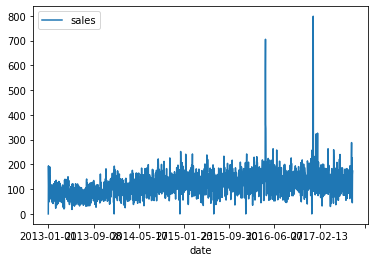

In [12]:
ts.plot()

In [13]:
sales_train, sales_test = train_test_split(ts, test_size=0.5, shuffle=False)
sales_test, sales_val = train_test_split(sales_test, test_size=0.5, shuffle=False)

In [18]:
sales_train

,sales
date,
2013-01-01,0.0
2013-01-02,194.0
2013-01-03,153.0
2013-01-04,88.0
2013-01-05,141.0
...,...
2015-04-20,151.0
2015-04-21,153.0
2015-04-22,150.0


In [19]:
sales_test

,sales
date,
2015-04-25,150.0
2015-04-26,47.0
2015-04-27,124.0
2015-04-28,122.0
2015-04-29,114.0
...,...
2016-06-15,163.0
2016-06-16,144.0
2016-06-17,121.0


In [20]:
sales_val

,sales
date,
2016-06-20,258.0
2016-06-21,116.0
2016-06-22,153.0
2016-06-23,154.0
2016-06-24,111.0
...,...
2017-08-11,53.0
2017-08-12,227.0
2017-08-13,45.0


# Analysis

## Seasonal Decomposing

In [ ]:
ts_decomp = tsa.seasonal_decompose(ts, period=365)

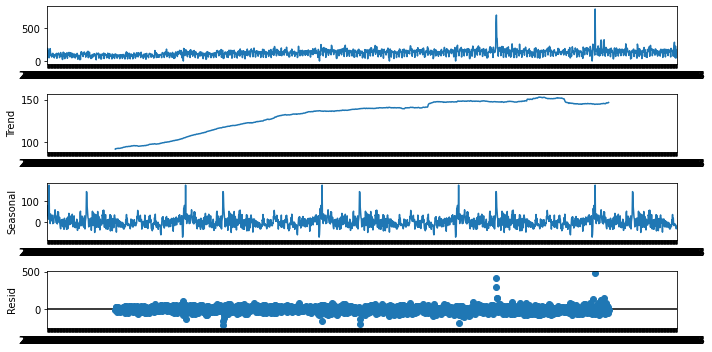

In [ ]:
ts_decomp.plot();

## Stationarity

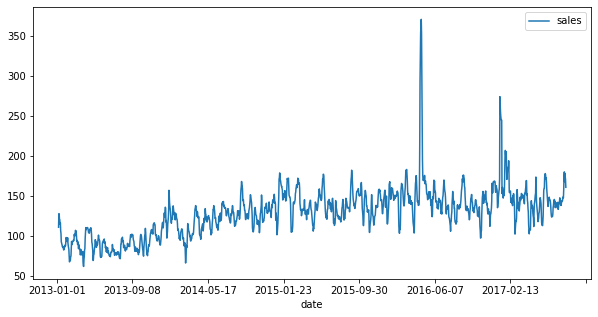

In [21]:
ts.rolling(7).mean().plot();

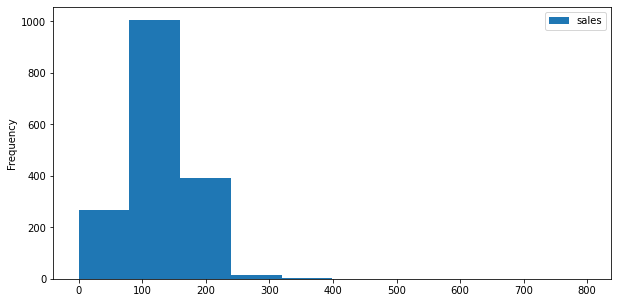

In [22]:
ts.plot.hist();

## 1st order difference

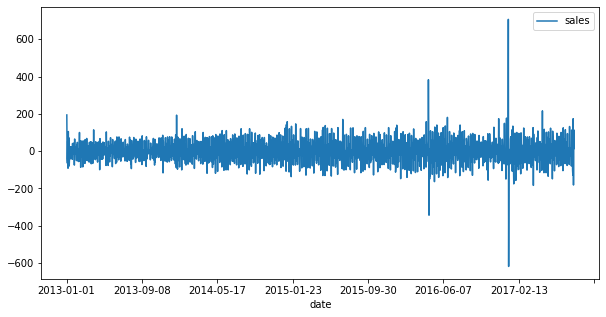

In [23]:
ts.diff().plot()

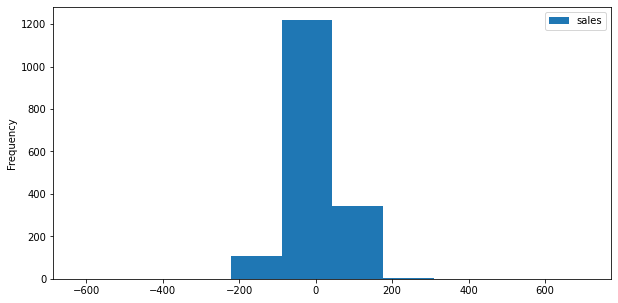

In [24]:
ts.diff().plot.hist();

In [25]:
ts_diff = ts.diff().dropna()

## Autocorrelation

A correlation of a variable with itself at different times
is known as autocorrelation or serial correlation.

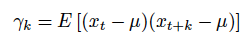

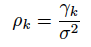

In [26]:
ts.shift(-1)

,sales
date,
2013-01-01,194.0
2013-01-02,153.0
2013-01-03,88.0
2013-01-04,141.0
2013-01-05,49.0
...,...
2017-08-11,227.0
2017-08-12,45.0
2017-08-13,159.0


In [27]:
ts.corrwith(ts.shift(-1))

sales    0.278298
dtype: float64

In [28]:
ts_diff.corrwith(ts_diff.shift(-1))

sales   -0.507911
dtype: float64

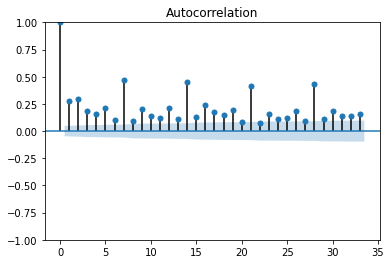

In [14]:
plot_acf(ts);

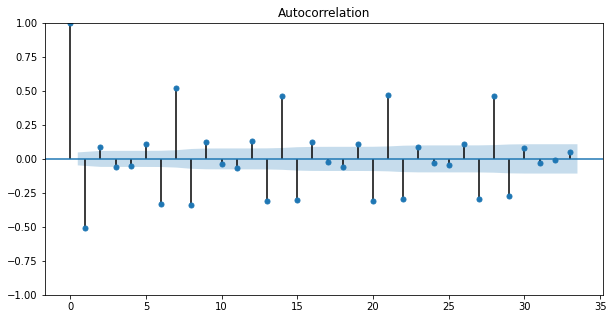

In [30]:
plot_acf(ts_diff);

## Partial Autocorrelation

The partial autocorrelation at lag k is the correlation that
results after removing the effect of any correlations due to the terms at shorter
lags.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


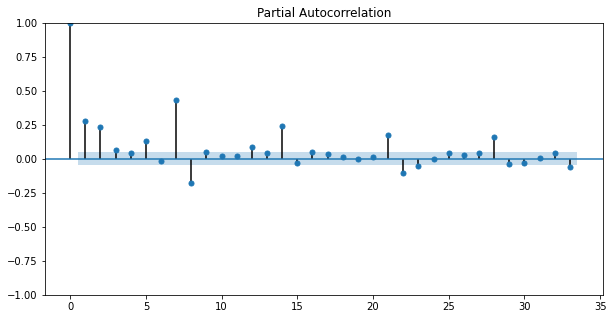

In [31]:
plot_pacf(ts);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


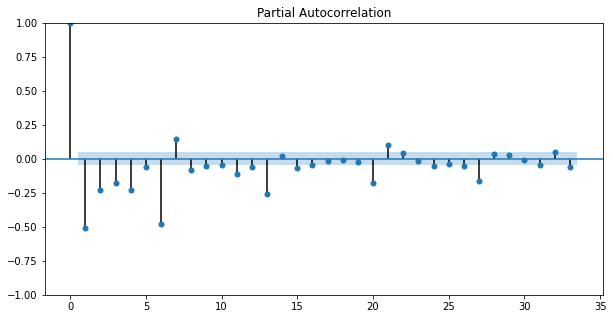

In [32]:
plot_pacf(ts_diff);

https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/

# Feature Engineering

In [15]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [34]:
get_lags(ts, 3)

,sales-1,sales-2,sales-3
date,,,
2013-01-04,153.0,194.0,0.0
2013-01-05,88.0,153.0,194.0
2013-01-06,141.0,88.0,153.0
2013-01-07,49.0,141.0,88.0
2013-01-08,154.0,49.0,141.0
...,...,...,...
2017-08-11,183.0,288.0,239.0
2017-08-12,53.0,183.0,288.0
2017-08-13,227.0,53.0,183.0


In [16]:
X = get_lags(ts, 7)
X.head()

,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7
date,,,,,,,
2013-01-08,154.0,49.0,141.0,88.0,153.0,194.0,0.0
2013-01-09,119.0,154.0,49.0,141.0,88.0,153.0,194.0
2013-01-10,190.0,119.0,154.0,49.0,141.0,88.0,153.0
2013-01-11,110.0,190.0,119.0,154.0,49.0,141.0,88.0
2013-01-12,81.0,110.0,190.0,119.0,154.0,49.0,141.0


In [23]:
X.reset_index(drop=True)

,sales-1,sales-2,sales-3,sales-4,sales-5,sales-6,sales-7
0,154.0,49.0,141.0,88.0,153.0,194.0,0.0
1,119.0,154.0,49.0,141.0,88.0,153.0,194.0
2,190.0,119.0,154.0,49.0,141.0,88.0,153.0
3,110.0,190.0,119.0,154.0,49.0,141.0,88.0
4,81.0,110.0,190.0,119.0,154.0,49.0,141.0
...,...,...,...,...,...,...,...
1672,183.0,288.0,239.0,187.0,74.0,154.0,138.0
1673,53.0,183.0,288.0,239.0,187.0,74.0,154.0
1674,227.0,53.0,183.0,288.0,239.0,187.0,74.0
1675,45.0,227.0,53.0,183.0,288.0,239.0,187.0


In [17]:
y = ts.reindex(X.index)

In [18]:
y.head()

,sales
date,
2013-01-08,119.0
2013-01-09,190.0
2013-01-10,110.0
2013-01-11,81.0
2013-01-12,103.0


In [31]:
y['sales']

date
2013-01-08    119.0
2013-01-09    190.0
2013-01-10    110.0
2013-01-11     81.0
2013-01-12    103.0
              ...  
2017-08-11     53.0
2017-08-12    227.0
2017-08-13     45.0
2017-08-14    159.0
2017-08-15    173.0
Name: sales, Length: 1677, dtype: float64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y['sales'], shuffle=False, test_size=.2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1341, 7)
(1341,)
(336, 7)
(336,)


E agora?

#SVR

In [33]:
from sklearn.svm import SVR

regr = SVR()
regr.fit(X_train, y_train)

SVR()

In [34]:
y_pred = regr.predict(X_test)

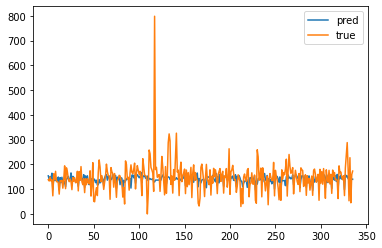

In [35]:
fig, ax = plt.subplots()

ax.plot(y_pred, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')

plt.legend()

In [36]:
results = {}
results['SVR'] = {'mape': mean_absolute_percentage_error(y_pred, y_test), 
                  'mse': mean_squared_error(y_pred, y_test), 
                  'mae': mean_absolute_error(y_pred, y_test)}

print('Sales Forecast - SVR Results')
print(results)

Sales Forecast - SVR Results
{'SVR': {'mape': 0.25458400610483956, 'mse': 3264.011938897812, 'mae': 34.26212521992928}}


## Grid Search

In [40]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


grid = {
    "kernel": ["rbf", "poly"], 
    "C": [1, 10, 100]
    }
    

grid_search = GridSearchCV(SVR(), 
                           grid, 
                           cv=TimeSeriesSplit(n_splits=5),
                           n_jobs=-1)

tuned_svr = grid_search.fit(X_train, y_train)

In [41]:
print(tuned_svr.best_score_)
print(tuned_svr.best_params_)

print('Grid Search - SVR Results')

results['SVR_GS'] = {'mse': mean_squared_error(tuned_svr.predict(X_test), y_test), 
                    'mae': mean_absolute_error(tuned_svr.predict(X_test), y_test),
                    'mape': mean_absolute_percentage_error(tuned_svr.predict(X_test), y_test)}

results

0.24520176407576993
{'C': 100, 'kernel': 'rbf'}
Grid Search - SVR Results


{'SVR': {'mae': 34.26212521992928,
  'mape': 0.25458400610483956,
  'mse': 3264.011938897812},
 'SVR_GS': {'mae': 31.270866996894863,
  'mape': 0.22567612646330865,
  'mse': 3021.6237457300317}}

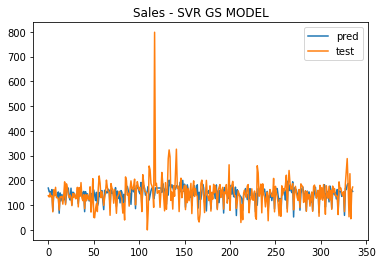

In [43]:
fig, ax = plt.subplots()

ax.plot(tuned_svr.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='test')

plt.title('Sales - SVR GS MODEL')
plt.legend()

In [29]:
y_train_multi = get_lags(pd.DataFrame(y_train), -7)
y_test_multi = get_lags(pd.DataFrame(y_test), -7)

In [30]:
X_train_multi, y_train_multi = X_train.align(y_train_multi, join='inner', axis=0) 
X_test_multi, y_test_multi = X_test.align(y_test_multi, join='inner', axis=0) 

In [31]:
X_train_multi.index is y_train_multi.index

True

In [32]:
X_test_multi.index is y_test_multi.index

True

In [33]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor

In [107]:
regr_multi = MultiOutputRegressor(LinearSVR(C=1.0, epsilon=0.2))

In [108]:
regr_multi.fit(X_train_multi, y_train_multi)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number

MultiOutputRegressor(estimator=LinearSVR(epsilon=0.2))

In [109]:
y_pred_multi = regr_multi.predict(X_test_multi)

In [110]:
regr_multi.predict(X_test_multi).shape

(329, 7)

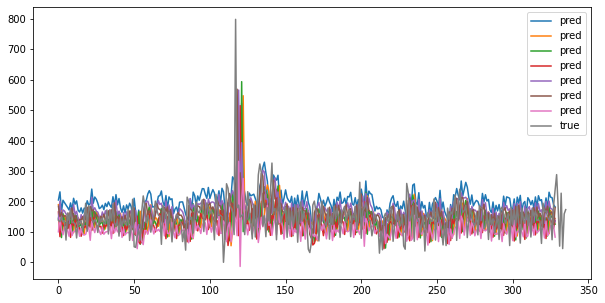

In [47]:
fig, ax = plt.subplots()

ax.plot(y_pred_multi, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')

plt.legend()

In [111]:
results['SVR Multi'] = {'mape': mean_absolute_percentage_error(y_pred_multi, y_test_multi),
                        'mse': mean_squared_error(y_pred_multi, y_test_multi), 
                        'mae': mean_absolute_error(y_pred_multi, y_test_multi)}

print('Sales Forecast - SVR Multi Results')
results

Sales Forecast - SVR Multi Results


{'SVR': {'mae': 41.331126829861226,
  'mape': 0.2846051426141686,
  'mse': 4022.839105099348},
 'SVR Multi': {'mae': 48.061604479413255,
  'mape': 0.33327200225833675,
  'mse': 5217.498999891684}}

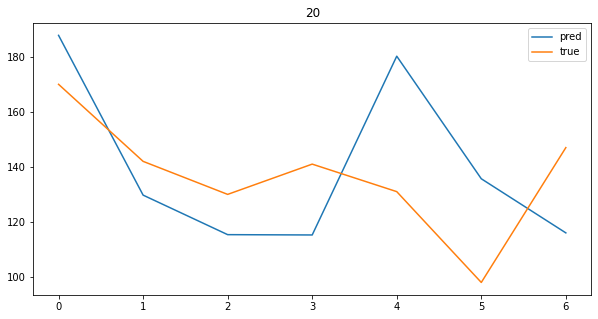

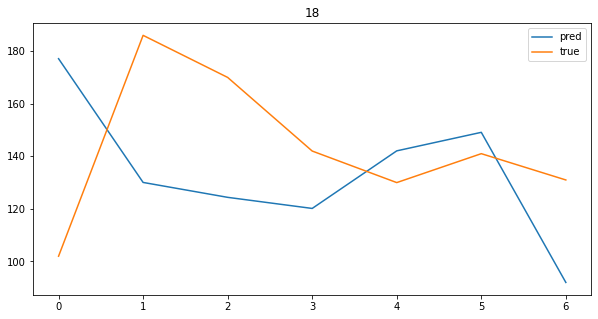

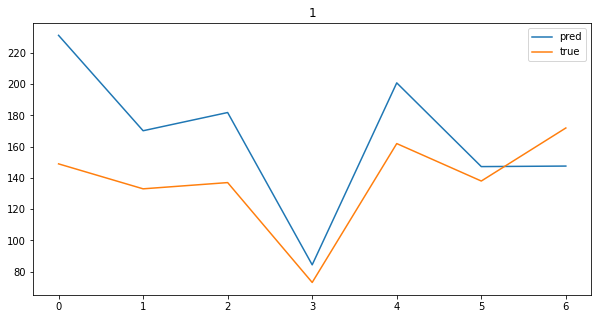

In [40]:
for day in np.random.randint(1, 100, 3):
  fig, ax = plt.subplots()
  pd.Series(y_pred_multi[day]).plot(label='pred')
  pd.Series(pd.DataFrame(y_test_multi).reset_index(drop=True).loc[day].values).plot(label='true')
  plt.title(day)
  plt.legend()

In [112]:
pd.DataFrame(results)

,SVR,SVR Multi
mape,0.284605,0.333272
mse,4022.839105,5217.499000
mae,41.331127,48.061604


# MLP

In [42]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

https://pytorch.org/tutorials/beginner/basics/intro.html

### Graphs

In [43]:
!sudo apt-get install graphviz graphviz-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.40.1-2).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 39 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2

In [48]:
pip install pygraphviz

     |████████████████████████████████| 118 kB 18.7 MB/s 
  Created wheel for pygraphviz: filename=pygraphviz-1.7-cp37-cp37m-linux_x86_64.whl size=165755 sha256=5c742146588b1098d6414f4c60c9b8ff06556b297146323039aba73ba2121f14
  Stored in directory: /root/.cache/pip/wheels/8c/bc/0c/ac35392b72556e75107ff610cb31b313e8471918a6d280e34c
Successfully built pygraphviz


In [49]:
import pygraphviz

In [50]:
import networkx as nx

In [51]:
g1 = nx.DiGraph()
for i in range(1,6):
  g1.add_edge(i,'n1')
g1.add_edge('n1','out')
A = nx.nx_agraph.to_agraph(g1)
A.draw("g1.png", prog="dot", )

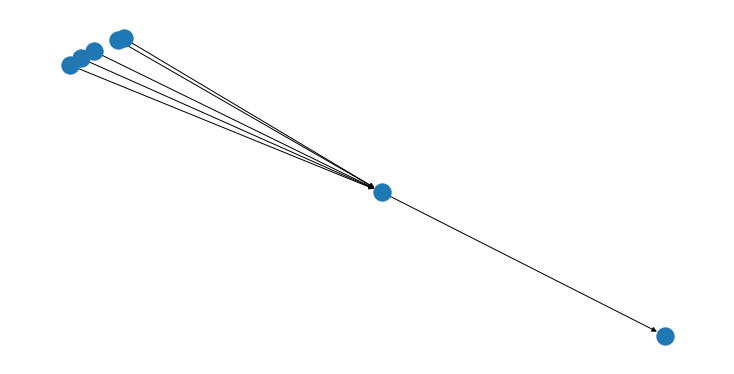

In [52]:
nx.draw_kamada_kawai(g1)

In [56]:
camada_entrada = [1,2,3,4]
neuronios = [[1,2,3,4],[1,2,3,4],[1,2,3,4]]
ativacao = relu(neuronios)
output = ativacao

erro = grad(neuronios)

NameError: ignored

In [57]:
g2 = nx.DiGraph()
"""
# X
for i in range(1,5):
  g2.add_node(i)

# y
g2.add_node('out')

# Neurons
for j in ('n1','n2','n3'):
  g2.add_node(j)
"""
# Conexões
for i in range(1,5):
  for j in ('n1','n2','n3'):
    g2.add_edge(i,j)
    g2.add_edge(j,'out')
B = nx.nx_agraph.to_agraph(g2)
B.draw("g2.png", prog="dot")

In [58]:
g3 = g2.reverse()
C = nx.nx_agraph.to_agraph(g3)
C.draw("g3.png", prog="dot")

In [59]:
g4 = nx.DiGraph()
# Conexões
for i in range(1,5):
  for j in ('n11','n12','n13'):
    g4.add_edge(i,j)
    for k in ('n21','n22','n23', 'n24', 'n25'):
      g4.add_edge(j,k)
      for l in ('n31','n32','n33', 'n34', 'n35', 'n36', 'n37'):
        g4.add_edge(k,l)
        g4.add_edge(l,'out')
D = nx.nx_agraph.to_agraph(g4)
D.draw("g4.png", prog="dot")

In [61]:
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

### Normalization

In [62]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

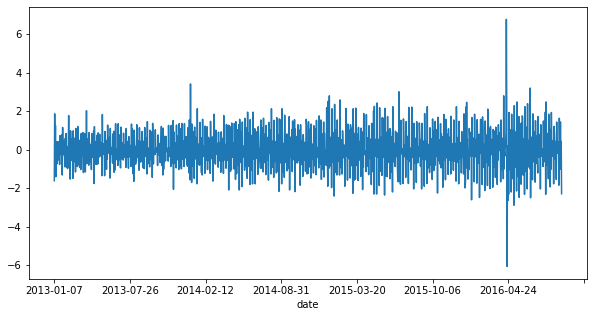

In [65]:
X_train_d1_norm['sales-1'].plot()

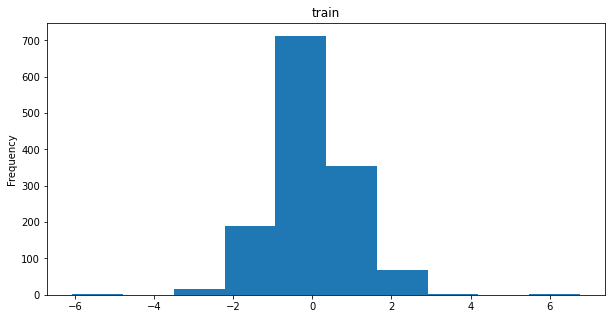

In [66]:
X_train_d1_norm['sales-1'].plot.hist(title='train')

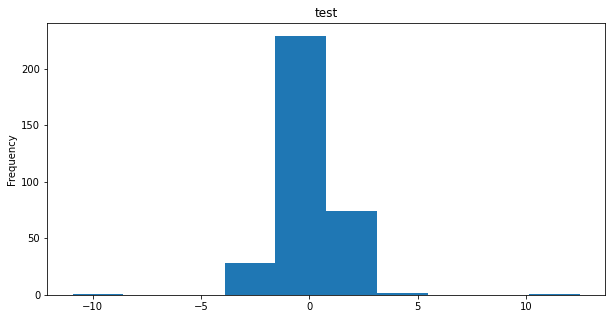

In [67]:
X_test_d1_norm['sales-1'].plot.hist(title='test')

### Tensors

![](https://miro.medium.com/max/654/1*8jdzMrA33Leu3j3F6A8a3w.png)

#### Batches

In [68]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)

In [69]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

### ANN

In [72]:
class OP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(5,1)
    
  def forward(self, X):
    out = torch.relu(self.fc(X))
    return out

In [73]:
one_neuron = OP()
print(one_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([0.], grad_fn=<ReluBackward0>)
sales    105.0
Name: 2013-01-07, dtype: float64


In [74]:
one_neuron = OP()
epochs = 50
loss_fn = nn.MSELoss()
optimizer = optim.SGD(one_neuron.parameters(), lr=0.001)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, loss 3207.2496722993396
Epoch 2, loss 3207.194367181687
Epoch 3, loss 3207.1541413806735
Epoch 4, loss 3207.125558762323
Epoch 5, loss 3207.1020224434988
Epoch 6, loss 3207.08423941476
Epoch 7, loss 3207.070813860212
Epoch 8, loss 3207.059095110212
Epoch 9, loss 3207.050531296503
Epoch 10, loss 3207.0435376848495
Epoch 11, loss 3207.0389455159507
Epoch 12, loss 3207.0364764985584
Epoch 13, loss 3207.0345604306176
Epoch 14, loss 3207.0331093924387
Epoch 15, loss 3207.0318160284132
Epoch 16, loss 3207.030304681687
Epoch 17, loss 3207.0291987827845
Epoch 18, loss 3207.0284641810827
Epoch 19, loss 3207.0274956112817
Epoch 20, loss 3207.026838030134
Epoch 21, loss 3207.0263235909597
Epoch 22, loss 3207.0257611955917
Epoch 23, loss 3207.0253622872488
Epoch 24, loss 3207.0250854492188
Epoch 25, loss 3207.0248216901505
Epoch 26, loss 3207.0245986211867
Epoch 27, loss 3207.024418422154
Epoch 28, loss 3207.0242200578964
Epoch 29, loss 3207.0240689232237
Epoch 30, loss 3207.023864019485


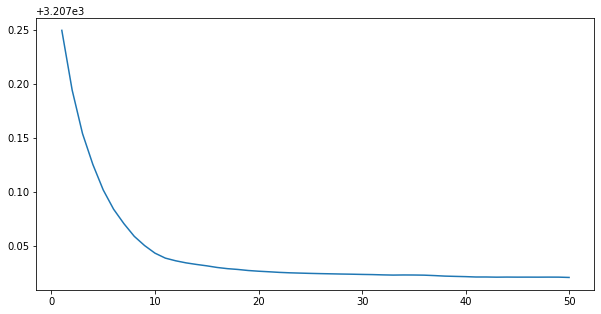

In [76]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = one_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  print('Epoch {}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()



In [77]:
one_neuron.eval() #desliga o treinamento do modelo
results = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = one_neuron(x)
    results.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results[:10]

[0.0809406, 0.0, 0.0, 0.0, 0.0, 0.015164778, 0.0007694885, 0.0, 0.0, 0.0]

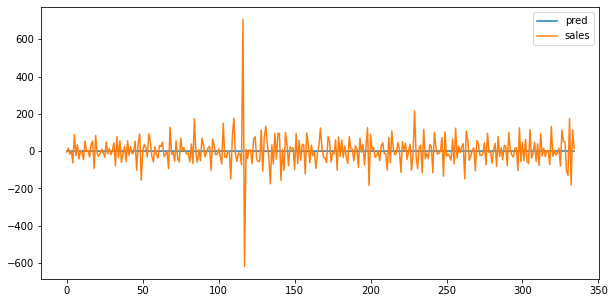

In [78]:
pd.concat([pd.Series(results, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [ ]:
l

In [113]:
results['NN'] = {'mape': mean_absolute_percentage_error(results, y_test_d1),
                  'mse': mean_squared_error(results, y_test_d1), 
                  'mae': mean_absolute_error(results, y_test_d1)}

print('Sales Forecast - NN Results')
print(results)

ValueError: ignored

In [83]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(5,100)
    self.fc3 = nn.Linear(100,1)
    #self.drop1 = nn.Dropout(p=0.5)
    #self.fc2 = nn.Linear(64,32)
    #self.drop2 = nn.Dropout(p=0.5)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    #out = self.drop1(out)
    #out = torch.relu(self.fc2(out))
    #out = self.drop2(out)
    out = self.fc3(out)
    return out

In [84]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([-0.5328], grad_fn=<AddBackward0>)
sales    105.0
Name: 2013-01-07, dtype: float64


In [85]:
multi_neuron = MLP()
epochs = 1000
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch10, loss 3207.2514452253067
Epoch20, loss 3207.1122930617557
Epoch30, loss 3207.063983735584
Epoch40, loss 3207.0269303094774
Epoch50, loss 3206.99120367141
Epoch60, loss 3206.9561825706846
Epoch70, loss 3206.922101702009
Epoch80, loss 3206.8897218250095
Epoch90, loss 3206.860256376721
Epoch100, loss 3206.8359178815567
Epoch110, loss 3206.816423688616
Epoch120, loss 3206.8003445579893
Epoch130, loss 3206.784701392764
Epoch140, loss 3206.7703058151974
Epoch150, loss 3206.7600519089474
Epoch160, loss 3206.751416160947
Epoch170, loss 3206.7435055687315
Epoch180, loss 3206.7357170468285
Epoch190, loss 3206.7288280668713
Epoch200, loss 3206.7228560674757
Epoch210, loss 3206.717537289574
Epoch220, loss 3206.712615966797
Epoch230, loss 3206.70809500558
Epoch240, loss 3206.7037491571336
Epoch250, loss 3206.699478149414
Epoch260, loss 3206.6951722644626
Epoch270, loss 3206.6908743722097
Epoch280, loss 3206.6865655808224
Epoch290, loss 3206.6822466169083
Epoch300, loss 3206.6780540829614
Ep

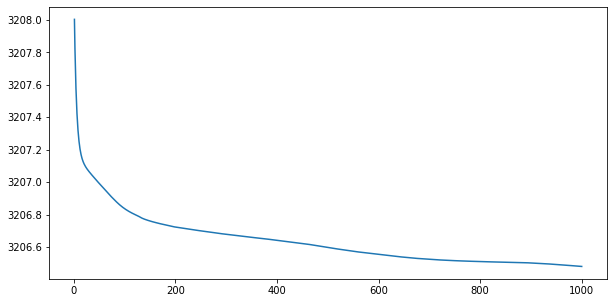

In [87]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  if (epoch % 10 == 0):
    print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()

In [115]:
multi_neuron.eval()
mlp_preds = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,:5].float()
    
    y_pred = multi_neuron(x)
    mlp_preds.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
mlp_preds[:10]

[-0.16888647,
 0.24765386,
 -0.12454228,
 -0.3549779,
 1.8049095,
 0.154216,
 -0.23842697,
 -0.20044975,
 0.7967076,
 1.064204]

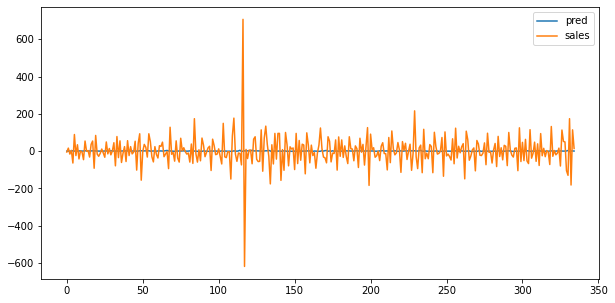

In [116]:
pd.concat([pd.Series(mlp_preds, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [122]:
mlp = {}

mlp['MLP'] = {'mape': mean_absolute_percentage_error(mlp_preds, y_test_d1),
                  'mse': mean_squared_error(mlp_preds, y_test_d1), 
                  'mae': mean_absolute_error(mlp_preds, y_test_d1)}

print('Sales Forecast - MLP Results')
print(mlp)

Sales Forecast - MLP Results
{'MLP': {'mape': 578.7460372207993, 'mse': 6801.967028006343, 'mae': 53.74761891800966}}


In [123]:
pd.DataFrame(mlp)

,MLP
mae,53.747619
mape,578.746037
mse,6801.967028


In [119]:
pd.DataFrame(results)

,SVR,SVR Multi,MLP
mape,0.284605,0.333272,578.746037
mse,4022.839105,5217.499000,6801.967028
mae,41.331127,48.061604,53.747619


Redes recorrentes:
* LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM
* GRU: https://pytorch.org/docs/stable/generated/torch.nn.GRU.html#torch.nn.GRU
